In [4]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
import bank_dataset
import importlib
from tqdm.notebook import tqdm
from torchinfo import summary
import math

importlib.reload(bank_dataset)

torch.manual_seed(43);

In [5]:
bank_dataset = bank_dataset.BankDataset("./bank_dataset.csv")
bank_dataset_train, bank_dataset_test = random_split(bank_dataset, [0.8, 0.2])
bank_dataloader_train = DataLoader(bank_dataset_train, batch_size=32, shuffle=True)
bank_dataloader_test = DataLoader(bank_dataset_test, batch_size=32, shuffle=True)

In [6]:
class AttentionHead(nn.Module):
    def __init__(self, embedding_size: int, head_size: int, causal_masking=True, dropout=0.0):
        super().__init__()
        self.q = nn.Linear(embedding_size, head_size, bias=False)
        self.k = nn.Linear(embedding_size, head_size, bias=False)
        self.v = nn.Linear(embedding_size, head_size, bias=False)
        self.head_size = head_size
        self.causal_masking = causal_masking
        self.do = nn.Dropout(dropout)

    def forward(self, X: Tensor):
        b, c, e = X.shape
        keys: Tensor = self.k(X)
        queries: Tensor = self.q(X)
        values = self.v(X)

        scores = queries.matmul(keys.transpose(-2, -1))
        scores = scores / torch.sqrt(torch.tensor(self.head_size))

        if self.causal_masking:
            mask = torch.tril(torch.ones(c, c))
            mask = mask.masked_fill(mask == 0, float("-inf"))
            scores += mask.unsqueeze(0)

        scores = F.softmax(scores, dim=-1)
        scores = self.do(scores)

        res = scores.matmul(values)

        return res

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, n_heads, causal_masking, dropout=0.0):
        super().__init__()
        assert embedding_dim % n_heads == 0

        head_size = embedding_dim // n_heads
        self.ath = nn.ModuleList([AttentionHead(embedding_dim, head_size, causal_masking, dropout) for _ in range(n_heads)])
        self.proj = nn.Linear(embedding_dim, embedding_dim)
        self.do = nn.Dropout(dropout)
    
    def forward(self, X):
        X = [ath(X) for ath in self.ath]
        X = torch.cat(X, dim=-1)
        X = self.proj(X)
        X = self.do(X)

        return X

In [8]:
class ResidualAdd(nn.Module):
    def __init__(self, inner: nn.Module):
        super().__init__()
        self.inner = inner

    def forward(self, X):
        r = self.inner(X)
        return r+X

In [9]:
class Transformer(nn.Module):
    def __init__(self, embedding_dim, n_heads, causal_masking, dropout=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            ResidualAdd(MultiHeadAttention(embedding_dim, n_heads, causal_masking, dropout)),
            nn.LayerNorm(embedding_dim),
            ResidualAdd(
                nn.Sequential(
                    nn.Linear(embedding_dim, embedding_dim * 4),
                    nn.ReLU(),
                    nn.Linear(embedding_dim * 4, embedding_dim), # projection
                    nn.Dropout(dropout)
                )
            ),
        )

    def forward(self, X):
        return self.layers(X)

In [10]:
# https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, X: torch.Tensor):
        seq_len = X.size(1)
        X = X + self.pe[:seq_len, :].unsqueeze(0)
        return X

class PositionalEmbedding(nn.Module):
    """
    A PyTorch Module for learnable positional embeddings.

    This module creates an embedding layer where each position up to
    `max_sequence_length` has a unique, learnable vector.
    These positional vectors are added to the token embeddings.
    """
    def __init__(self, max_len: int, embedding_dim: int):
        super().__init__()
        self.max_len = max_len
        self.embedding_dim = embedding_dim

        self.position_embeddings = nn.Embedding(max_len, embedding_dim)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        sequence_length = X.size(1)
        assert sequence_length <= self.max_len
        positions = torch.arange(sequence_length, dtype=torch.long, device=X.device).unsqueeze(0)
        positional_encodings = self.position_embeddings(positions)

        return X + positional_encodings

In [11]:
class BertProMax(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, transformer_count, n_heads, n_classes, positional_encoding, causal_masking, dropout=0.0):
        super().__init__()
        self.embeddings = nn.Embedding(n_embeddings, embedding_dim)
        if positional_encoding:
            self.positional_encoder = PositionalEncoding(embedding_dim)
            #self.positional_encoder = PositionalEmbedding(bank_dataset.context_window_size, embedding_dim)
        self.positional_encoding = positional_encoding
        self.layers = nn.Sequential(
            *(Transformer(embedding_dim, n_heads, causal_masking, dropout) for _ in range(transformer_count)),
            nn.Linear(embedding_dim, n_classes),
        )
        self.do = nn.Dropout(dropout)
        
    def forward(self, X):
        X = self.embeddings(X)
        if self.positional_encoding:
            X = self.positional_encoder(X)
        X = self.do(X)
        X = self.layers(X)
        X = X.mean(dim=1)
        return X

In [12]:
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=4,
    transformer_count=1,
    n_heads=2,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True,
)

summary(model, input=(26,), dtypes=[torch.int])

Layer (type:depth-idx)                                  Param #
BertProMax                                              --
├─Embedding: 1-1                                        2,604
├─PositionalEncoding: 1-2                               --
├─Sequential: 1-3                                       --
│    └─Transformer: 2-1                                 --
│    │    └─Sequential: 3-1                             232
│    └─Linear: 2-2                                      15
├─Dropout: 1-4                                          --
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0

In [13]:
@torch.no_grad()
def val(model: nn.Module, loss_fn):
    total_val_loss = 0
    for x, y in bank_dataloader_test:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        total_val_loss += loss
    avg_val_loss = total_val_loss / len(bank_dataloader_test)
    return avg_val_loss

In [14]:
def train(model: nn.Module, epochs, optimizer, loss_fn):
    model.train(True)
    train_losses = []
    val_losses = []
    for _ in tqdm(range(epochs)):
        epoch_train_losses = 0
        c = 0
        for x, y in bank_dataloader_train:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_train_losses += loss
            c += 1
            loss.backward()
            optimizer.step()
        model.train(False)
        val_losses.append(val(model, loss_fn))
        model.train(True)
        train_losses.append(epoch_train_losses / c)
    model.train(False)

    return train_losses, val_losses

In [15]:
@torch.no_grad
def eval(index: int):
    x, y = bank_dataset.__getitem__(index)
    y_pred = model(x.unsqueeze(0))
    s = F.softmax(y_pred, dim=-1) 
    highest_class = torch.argmax(s)
    print(bank_dataset.df["Satz"][index])
    print(f"Predicted: {bank_dataset.index2label(highest_class.item())} ({s[0][highest_class].item()*100}%)")
    print(f"True:      {bank_dataset.index2label(y.item())}")

In [16]:
loss_fn = nn.CrossEntropyLoss()

In [17]:
@torch.no_grad
def loss_eval(index: int):
    x, y = bank_dataset.__getitem__(index)
    y_pred = model(x.unsqueeze(0))
    return loss_fn(y_pred, y.unsqueeze(0))

EPOCHS = 200

In [18]:
train_losses = []
val_losses = []

loss_fn = nn.CrossEntropyLoss()

# Variant 1: Old model
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=1,
    n_heads=3,
    n_classes=3,
    positional_encoding=False,
    causal_masking=False
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

# Variant 2: With MMHA
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=1,
    n_heads=3,
    n_classes=3,
    positional_encoding=False,
    causal_masking=True
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

# Variant 3: With Positional Encoding
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=1,
    n_heads=3,
    n_classes=3,
    positional_encoding=True,
    causal_masking=False
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

# Variant 4: Multiple Encoder-Cores (Transformer Layers I guess?)
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=3,
    n_heads=3,
    n_classes=3,
    positional_encoding=False,
    causal_masking=False
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
# Variant 5: Everything
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=3,
    n_heads=3,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
# Variant 6: Everything big
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=16,
    transformer_count=8,
    n_heads=4,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Variant 7: Everything big + Dropouts
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=6,
    transformer_count=3,
    n_heads=3,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True,
    dropout=0.2
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
# Variant 8: Everything big + Dropouts
model = BertProMax(
    n_embeddings=bank_dataset.unique_word_count,
    embedding_dim=16,
    transformer_count=8,
    n_heads=4,
    n_classes=3,
    positional_encoding=True,
    causal_masking=True,
    dropout=0.0
)
optimizer = AdamW(model.parameters())
t, v = train(model, EPOCHS, optimizer, loss_fn)
train_losses.append(t)
val_losses.append(v)

  0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
# Variant 8: Everything biggest + Dropouts
# model = BertProMax(
#     n_embeddings=bank_dataset.unique_word_count,
#     embedding_dim=32,
#     transformer_count=16,
#     n_heads=8,
#     n_classes=3,
#     positional_encoding=True,
#     causal_masking=True,
#     dropout=0.2
# );
# optimizer = AdamW(model.parameters())
# t, v = train(model, EPOCHS, optimizer, loss_fn)
# train_losses.append(t)
# val_losses.append(v)

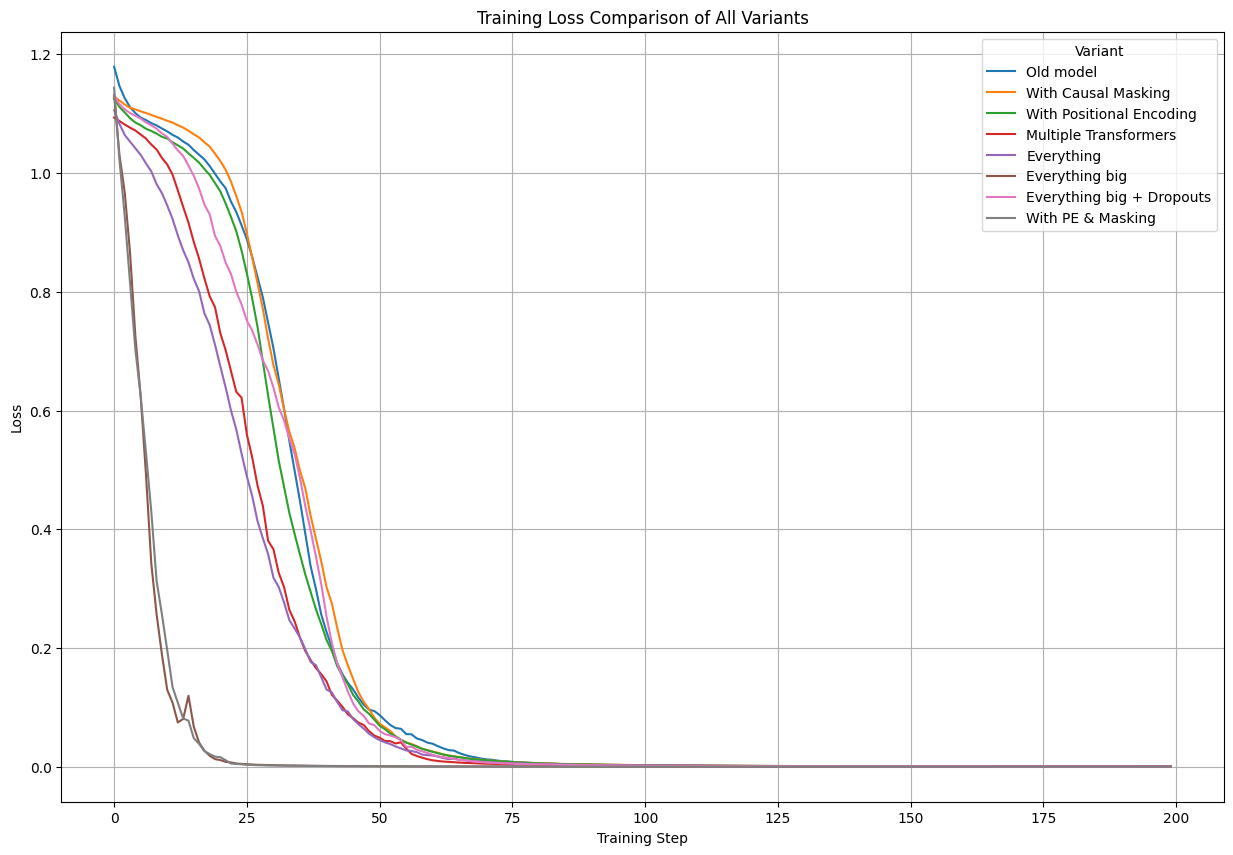

In [24]:
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt

variant_names = [
    "Old model",
    "With Causal Masking",
    "With Positional Encoding",
    "Multiple Transformers",
    "Everything",
    "Everything big",
    "Everything big + Dropouts",
    "With PE & Masking"
    # "Everything biggest + Dropouts"
]

plot_data = []
for i, variant_losses in enumerate(train_losses):
    losses_float = [loss.item() for loss in variant_losses]
    
    df_variant = pl.DataFrame({
        'Step': range(len(losses_float)),
        'Loss': losses_float,
        'Variant': variant_names[i]
    })
    plot_data.append(df_variant)

full_plot_data = pl.concat(plot_data)

plt.figure(figsize=(15, 10))
sns.lineplot(data=full_plot_data, x='Step', y='Loss', hue='Variant', errorbar=None)
plt.title('Training Loss Comparison of All Variants')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(title='Variant')
plt.show()

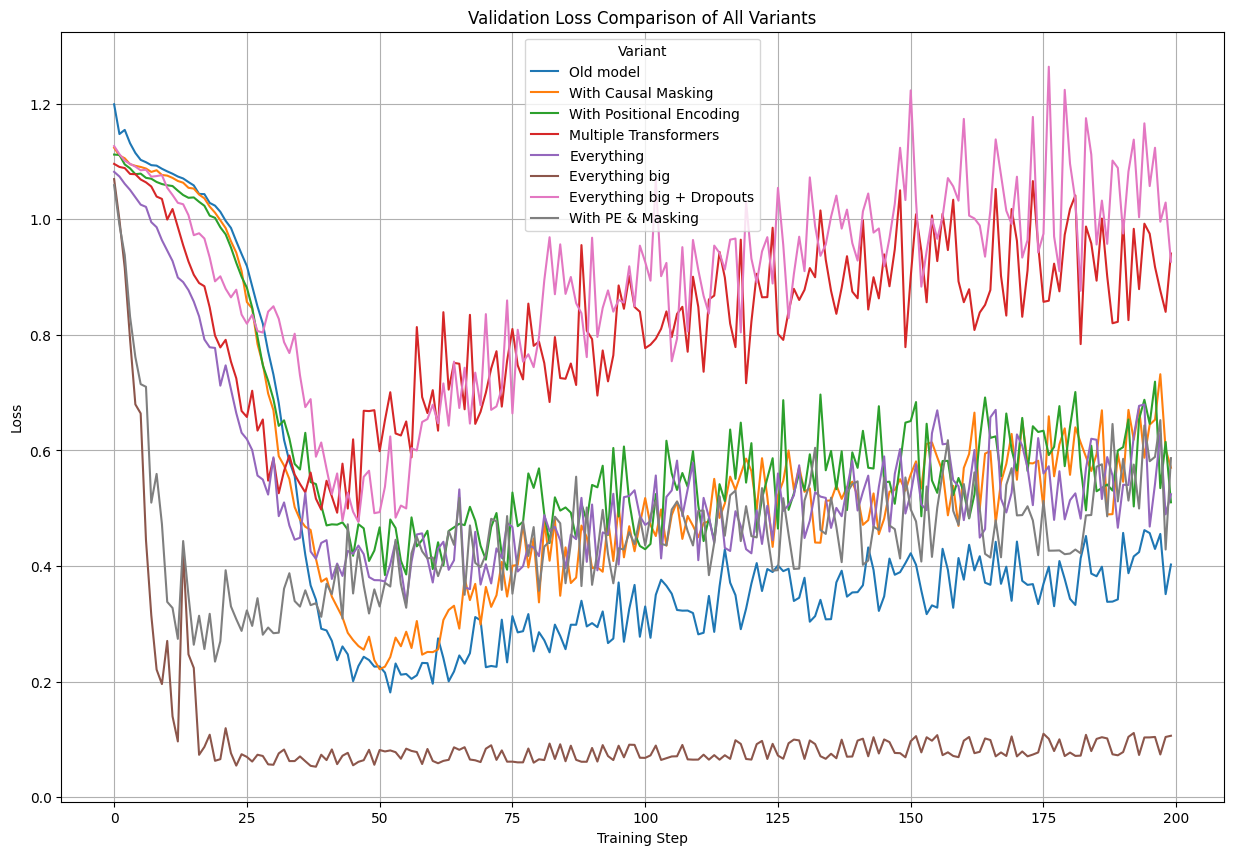

In [25]:
plot_data = []
for i, variant_losses in enumerate(val_losses):
    losses_float = [loss.item() for loss in variant_losses]
    
    df_variant = pl.DataFrame({
        'Step': range(len(losses_float)),
        'Loss': losses_float,
        'Variant': variant_names[i]
    })
    plot_data.append(df_variant)

full_plot_data = pl.concat(plot_data)

plt.figure(figsize=(15, 10))
sns.lineplot(data=full_plot_data, x='Step', y='Loss', hue='Variant', errorbar=None)
plt.title('Validation Loss Comparison of All Variants')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(title='Variant')
plt.show()

<Axes: >

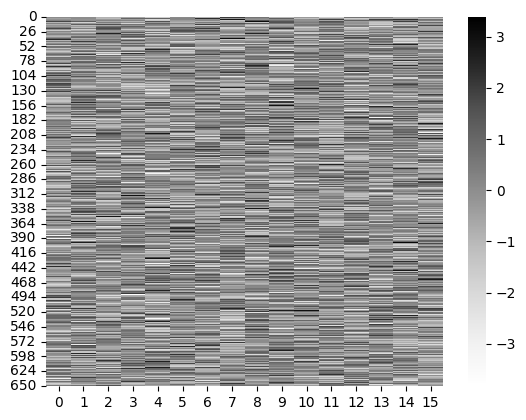

In [26]:
sns.heatmap(data=model.embeddings.weight.detach().numpy(), cmap="Grays")

torch.Size([651, 16])


<Axes: >

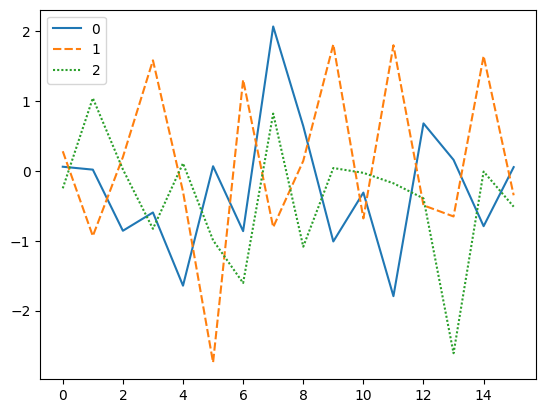

In [27]:
m =model.embeddings.weight.detach() 
print(m.shape)
sns.lineplot(data=model.embeddings.weight.detach()[[1,620, 540], :].T)

<Axes: >

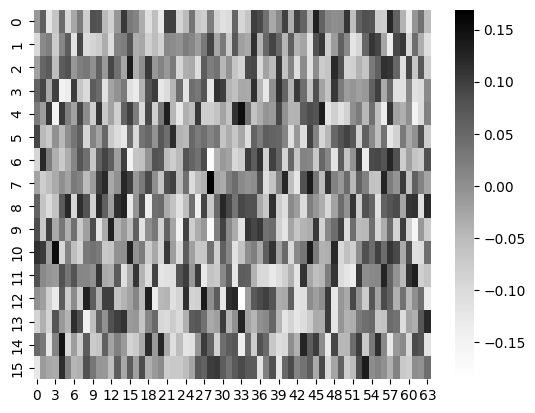

In [28]:
sns.heatmap(data=model.layers[0].layers[3].inner[2].weight.detach().numpy(), cmap="Grays")